In [11]:
###··· BANK DATASET ···### 
import pandas as pd
from matplotlib import pyplot as plt
from seaborn import heatmap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import *
import numpy as np

# Part 1: Selecting and analyzing the dataset 
# #Load the dataset
bank_dataset = pd.read_csv("A2-bank/bank-additional.csv", sep=';', header=0)
#Drop unnused columns
bank_dataset.drop(["default", "day_of_week","pdays"], axis=1, inplace=True)

#Replace unknown values with the mode
for column in ["marital", "job", "education", "housing", "loan"]:
    bank_dataset[column].replace("unknown", bank_dataset[column].mode()[0], inplace=True)

#Give a numerical value to the categorical data
columns_to_factorize = ["job", "marital", "education", "housing", "loan", "contact", "month", "poutcome", "y"]
for column in columns_to_factorize:
    bank_dataset[column], _ = pd.factorize(bank_dataset[column])


x_train = bank_dataset[["job", "marital", "education", "housing", "loan", "contact", "month", "duration", "campaign", "previous", "poutcome", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]]
y_train = bank_dataset[["y"]]

# Scale the dat
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)

x_train, x_test, y_train, y_test = train_test_split(x_train_scaled, y_train, test_size=0.2, shuffle=True)

You need to select one of the 3 models (BP, MLR or SVM) to generate the grid cross validation function. Then, execute the following script 2.2 to fit the model and generate the prediction:

In [6]:
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasClassifier
tf.get_logger().setLevel('ERROR')

# Create the model
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(x_train.shape[1],), activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cv_model = KerasClassifier(model=model, verbose=0)
# Perform cross-validation
grid = GridSearchCV(estimator=cv_model,
                    param_grid= {'epochs' : [50], 'optimizer__learning_rate': [0.1, 0.01, 0.001], 'optimizer__momentum' :[0.1, 0.01, 0.001]},
                    cv=5, 
                    scoring='accuracy')

In [ ]:
###···Part 2.b: Implement MLR ···###
import sklearn.linear_model as lm
# Create the model
model = lm.LinearRegression()
# Perform cross-validation
grid = GridSearchCV(estimator=model,
                    param_grid= {'Cs': [1, 10], 'solver': ['newton-cg', 'lbfgs','saga']},
                    cv=5, 
                    scoring='accuracy')

In [20]:
###···Part 2.c: Implement SVM ···###
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.svm as svm
# Create the model
C= [0.01, 1, 100, 1000]
gamma = [0.1, 1, 10, 'scale']
param_grid = dict(gamma=gamma, C=C, kernel=['linear', 'rbf'])         #Linear kernel fits is the best option to split the data y groups
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)


Now fit the result and get the predicted values. With predicted values.

In [21]:
#---Part 2.2: Fit the program and obtain results---#
# Fit the model
grid.fit(x_train, y_train.values.ravel())
# summarize results
print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
print("Classification error: ", 1 - grid.best_score_)
# Predict the response for test dataset
y_train_pred = grid.predict(x_train)
y_test_pred = grid.predict(x_test)

print("---Train---")
print("Accuracy Score: ", accuracy_score(y_train, y_train_pred))
print("---Test---")
print("Accuracy Score: ", accuracy_score(y_test, y_test_pred))

pd.DataFrame(grid.cv_results_)

With predicted values, you can now evaluate the accuracy with confusion matrix, ROC curve and plotting the predicted data with heatmap

[[7167  131]
 [ 639  301]]


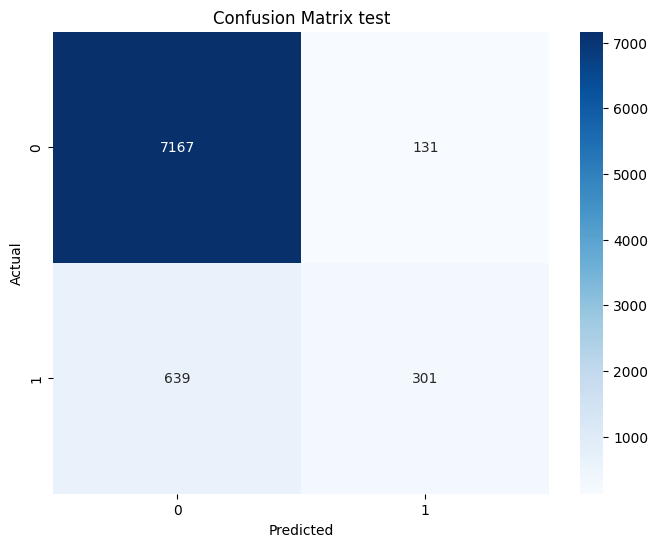

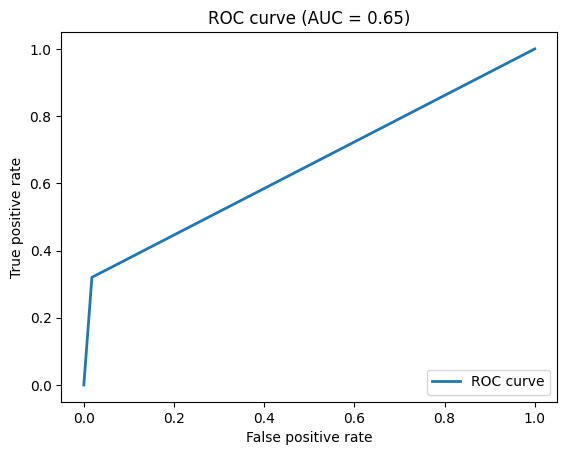

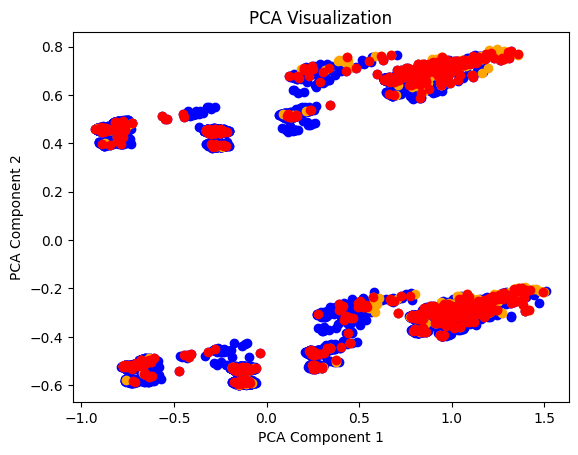

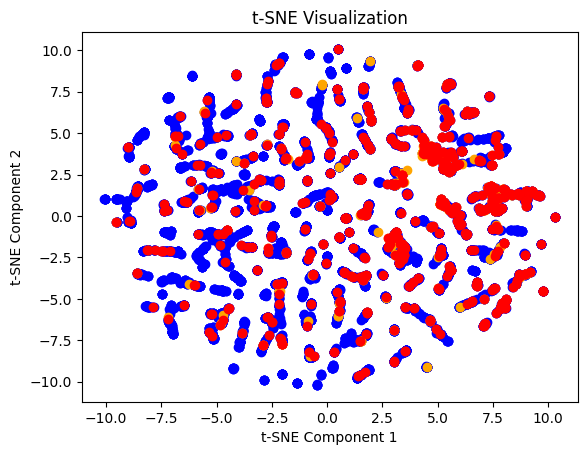

In [17]:
#---Part 3: Evaluate the model and summarize results---#
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, roc_curve, auc
from seaborn import heatmap

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
print(confusion)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap(confusion, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix test')
plt.show()

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Plot ROC curve + AUC
plt.figure()
lw = 2
plt.plot(false_positive_rate, true_positive_rate, lw=lw, label='ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (AUC = %0.2f)' % roc_auc)
plt.legend(loc='lower right')
plt.show()

# Plot data using PCA visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_test)
x_pca_df = pd.DataFrame(data=x_pca, columns=['pca1', 'pca2'])
x_pca_df['class'] = y_test_pred

# Plot the PCA results
plt.scatter(x_pca_df['pca1'][y_test_pred == 0], x_pca_df['pca2'][y_test_pred == 0], c='blue', marker="o")
plt.scatter(x_pca_df['pca1'][y_test_pred == 1], x_pca_df['pca2'][y_test_pred == 1], c='orange', marker="o")
plt.scatter(x_pca_df['pca1'][y_test_pred != np.array(y_test).flatten()], x_pca_df['pca2'][y_test_pred != np.array(y_test).flatten()], c='red', marker="o")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization')
plt.show()


# Plot data using T-SNE visulization
tsne = TSNE(n_components=2, perplexity=4, n_iter=250)
x_tsne = tsne.fit_transform(x_test)

x_tsne_df = pd.DataFrame(data=x_tsne, columns=['tsne1', 'tsne2'])
x_tsne_df['class'] = y_test_pred

# Plot the t-SNE results
plt.scatter(x_tsne_df['tsne1'][y_test_pred == 0], x_tsne_df['tsne2'][y_test_pred == 0], c='blue', marker="o")
plt.scatter(x_tsne_df['tsne1'][y_test_pred == 1], x_tsne_df['tsne2'][y_test_pred == 1], c='orange', marker="o")
plt.scatter(x_tsne_df['tsne1'][y_test_pred != np.array(y_test).flatten()], x_tsne_df['tsne2'][y_test_pred != np.array(y_test).flatten()], c='red', marker="o")
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()

